### Importação de Bibliotecas

In [1]:
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import accuracy_score
import numpy as np

### Carregamento e Pré-Processamento dos Dados

In [2]:
# Carregar o ficheiro arff
data, meta = arff.loadarff('diabetes.arff')
df = pd.DataFrame(data)

# Converter atributos do formato bytes para strings e depois para numéricos
df = df.apply(lambda col: col.map(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x))
df = df.apply(pd.to_numeric)

# Alterar os valores de Outcome: 0 -> 'Normal', 1 -> 'Diabetes'
df['Outcome'] = df['Outcome'].map({0: 'Normal', 1: 'Diabetes'})

# Definir características (X) e rótulo (y)
X = df.iloc[:, :-1]  # Todas as colunas exceto a última
y = df['Outcome']    # Coluna de resultado ("Normal" ou "Diabetes")


### Exercício 1

Melhor característica: Glucose, F-score: 213.16175217803828
Pior característica: BloodPressure, F-score: 3.256950397889028


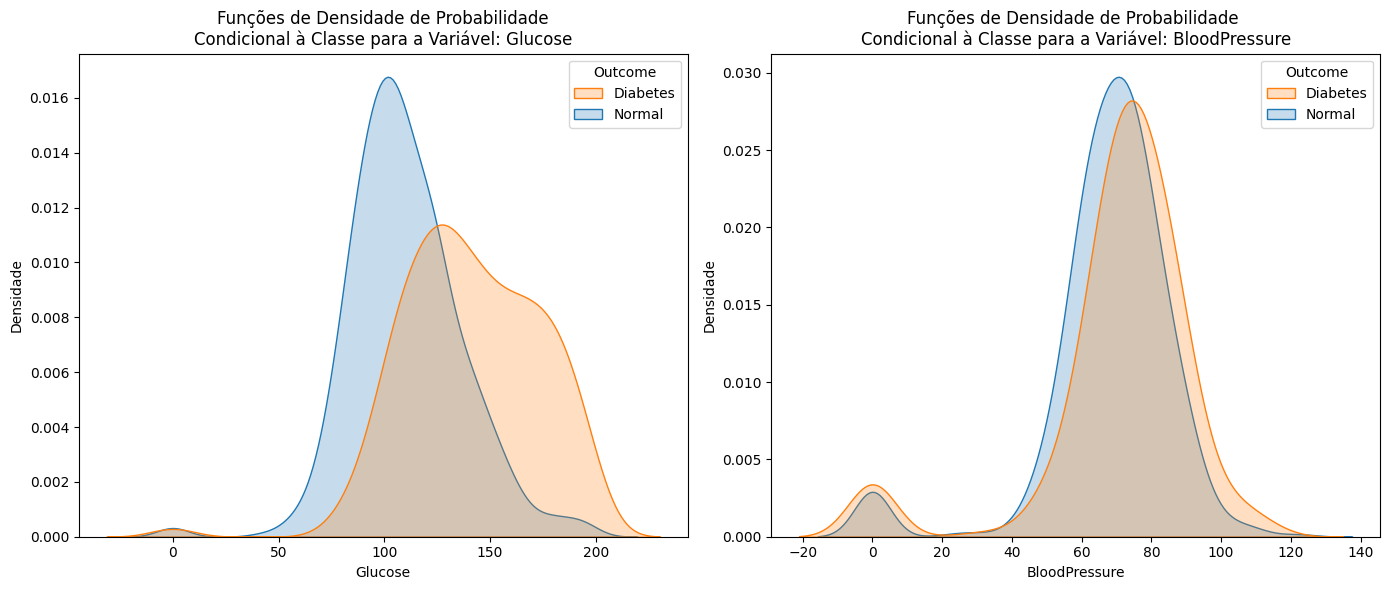

In [3]:
# Calcular F-score e p-valor usando f_classif
f_values, p_values = f_classif(X, y)

# Identificar a característica com melhor (maior F-score) e pior (menor F-score) discriminative power
best_feature = X.columns[f_values.argmax()]  # Maior F-score
worst_feature = X.columns[f_values.argmin()] # Menor F-score

# Exibir resultados
print(f"Melhor característica: {best_feature}, F-score: {f_values.max()}")
print(f"Pior característica: {worst_feature}, F-score: {f_values.min()}")

# Definir a paleta de cores para "Normal" e "Diabetes"
palette = {"Normal": "#1f77b4", "Diabetes": "#ff7f0e"}

# Passo 2: Representar graficamente as funções de densidade de probabilidade condicional à classe
plt.figure(figsize=(14, 6))

# Melhor característica
plt.subplot(1, 2, 1)
sns.kdeplot(data=df, x=best_feature, hue='Outcome', common_norm=False, fill=True, palette=palette)
plt.title(f'Funções de Densidade de Probabilidade\nCondicional à Classe para a Variável: {best_feature}')
plt.ylabel('Densidade')

# Pior característica
plt.subplot(1, 2, 2)
sns.kdeplot(data=df, x=worst_feature, hue='Outcome', common_norm=False, fill=True, palette=palette)
plt.title(f'Funções de Densidade de Probabilidade \nCondicional à Classe para a Variável: {worst_feature}')
plt.ylabel('Densidade')

plt.tight_layout()
plt.show()


### Exercício 2

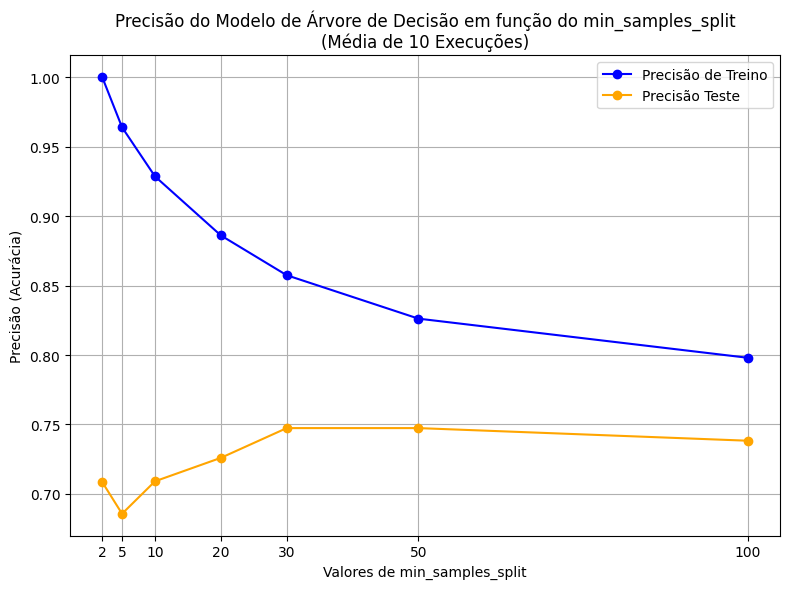

In [4]:
# Definir valores para min_samples_split e inicializar variáveis para armazenar as acurácias
min_samples_splits = [2, 5, 10, 20, 30, 50, 100]
train_accuracies = []
test_accuracies = []

# Número de execuções para cada configuração
n_runs = 10

# Loop sobre diferentes valores de min_samples_split
for min_samples in min_samples_splits:
    train_accs = []
    test_accs = []
    
    # Realizar múltiplas execuções
    for _ in range(n_runs):
        # Dividir os dados em conjuntos de treino e teste (80-20) com estratificação
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None, stratify=y)
        
        # Criar e treinar o modelo de árvore de decisão
        clf = DecisionTreeClassifier(min_samples_split=min_samples, random_state=1)
        clf.fit(X_train, y_train)
        
        # Prever as classes para o conjunto de treino e teste
        y_train_pred = clf.predict(X_train)
        y_test_pred = clf.predict(X_test)
        
        # Calcular as precisões (acurácias)
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        
        # Armazenar os resultados
        train_accs.append(train_accuracy)
        test_accs.append(test_accuracy)

    # Calcular a média e o desvio padrão das precisões (acurácias)
    train_accuracies.append((np.mean(train_accs), np.std(train_accs)))
    test_accuracies.append((np.mean(test_accs), np.std(test_accs)))

# Extrair médias e desvios padrão
train_means, train_stds = zip(*train_accuracies)
test_means, test_stds = zip(*test_accuracies)

# Representar graficamente os resultados
plt.figure(figsize=(8, 6))

# Precisão (Acurácia) de treino com erro padrão
plt.plot(min_samples_splits, train_means, marker='o', label='Precisão de Treino', color='blue')

# Precisão (Acurácia) de teste com erro padrão
plt.plot(min_samples_splits, test_means, marker='o', label='Precisão Teste', color='orange')

# Configurações do gráfico
plt.title('Precisão do Modelo de Árvore de Decisão em função do min_samples_split\n(Média de 10 Execuções)')
plt.xlabel('Valores de min_samples_split')
plt.ylabel('Precisão (Acurácia)')
plt.xticks(min_samples_splits)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


### Exercício 4

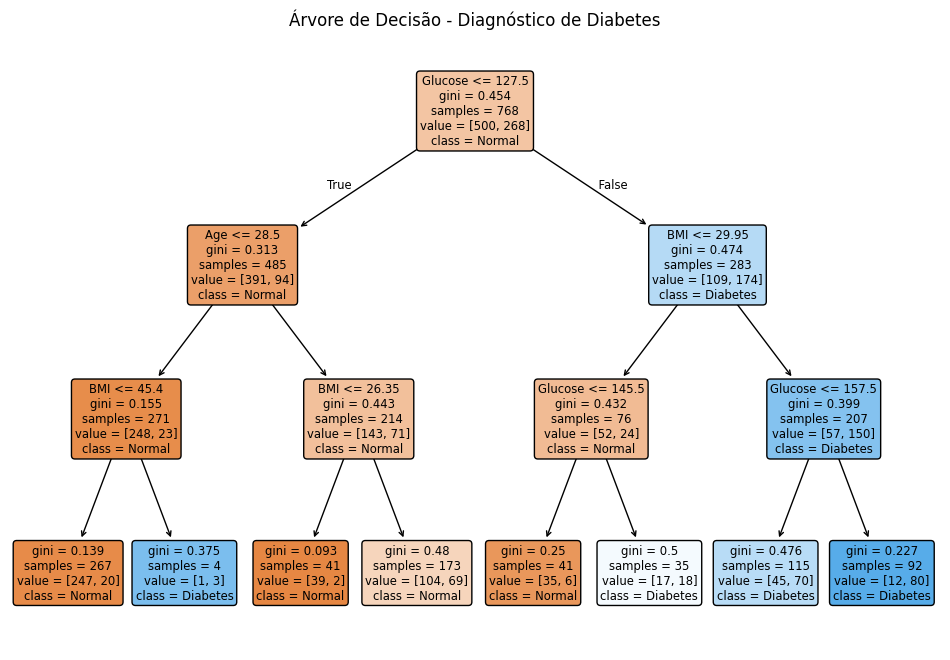

Regras da Árvore de Decisão:
|--- Glucose <= 127.50
|   |--- Age <= 28.50
|   |   |--- BMI <= 45.40
|   |   |   |--- class: 0
|   |   |--- BMI >  45.40
|   |   |   |--- class: 1
|   |--- Age >  28.50
|   |   |--- BMI <= 26.35
|   |   |   |--- class: 0
|   |   |--- BMI >  26.35
|   |   |   |--- class: 0
|--- Glucose >  127.50
|   |--- BMI <= 29.95
|   |   |--- Glucose <= 145.50
|   |   |   |--- class: 0
|   |   |--- Glucose >  145.50
|   |   |   |--- class: 1
|   |--- BMI >  29.95
|   |   |--- Glucose <= 157.50
|   |   |   |--- class: 1
|   |   |--- Glucose >  157.50
|   |   |   |--- class: 1

Probabilidades posteriores para cada folha [Classe 0 - Normal, Classe 1 - Diabetes]:
Folha 3: [0.92509363 0.07490637]
Folha 4: [0.25 0.75]
Folha 6: [0.95121951 0.04878049]
Folha 7: [0.60115607 0.39884393]
Folha 10: [0.85365854 0.14634146]
Folha 11: [0.48571429 0.51428571]
Folha 13: [0.39130435 0.60869565]
Folha 14: [0.13043478 0.86956522]


In [6]:
# Carregar o ficheiro arff
data, meta = arff.loadarff('diabetes.arff')
df = pd.DataFrame(data)

# Converter atributos do formato bytes para strings e numéricos
df = df.apply(lambda col: col.map(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x))
df = df.apply(pd.to_numeric)  # Converte todos os dados para formato numérico

# Definir características (X) e rótulo (y)
X = df.iloc[:, :-1]  # Todas as colunas exceto a última
y = df['Outcome']    # Coluna de resultado (0 ou 1)

# Criar e treinar o modelo de árvore de decisão com profundidade máxima de 3
clf = DecisionTreeClassifier(max_depth=3, random_state=1)
clf.fit(X, y)

# Representar graficamente a árvore de decisão
plt.figure(figsize=(12, 8))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=['Normal', 'Diabetes'], rounded=True)
plt.title('Árvore de Decisão - Diagnóstico de Diabetes')
plt.show()

# Imprimir as regras da árvore de decisão
rules = export_text(clf, feature_names=list(X.columns))
print("Regras da Árvore de Decisão:")
print(rules)

# Cálculo das probabilidades posteriores de cada folha
# Obter as probabilidades previstas pelo modelo para cada observação
y_pred_prob = clf.predict_proba(X)

# Definir as folhas da árvore para cada amostra
leaves_index = clf.apply(X)

# Calcular as probabilidades posteriores para cada folha
unique_leaves = np.unique(leaves_index)
leaf_probabilities = {}

for leaf in unique_leaves:
    # Extrair observações que terminam nesta folha
    leaf_samples = (leaves_index == leaf)
    
    # Calcular a proporção de classes "Diabetes" (1) e "Normal" (0) na folha
    count_classes = np.bincount(y[leaf_samples].astype(int))
    posterior_prob = count_classes / count_classes.sum()
    
    leaf_probabilities[leaf] = posterior_prob

# Exibir as probabilidades posteriores para cada folha
print("Probabilidades posteriores para cada folha [Classe 0 - Normal, Classe 1 - Diabetes]:")
for leaf, probs in leaf_probabilities.items():
    print(f"Folha {leaf}: {probs}")